### import packages

In [1]:
import tqdm
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

C:\Users\Masoud\AppData\Local\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [2]:
Xtr = pd.read_excel("Xtr.xlsx").iloc[:, 1:]
Ytr = pd.read_excel("Ytr.xlsx").iloc[:, 1:]
Xts = pd.read_excel("Xts.xlsx").iloc[:, 1:]
Yts = pd.read_excel("Yts.xlsx").iloc[:, 1:]
Xtr.shape, Xts.shape

((81840, 1), (16368, 1))

### Design Models 

In [64]:
class Config:
    EMB_DIM = 64
    N_HEADS = 8
    N_TRM_LAYERS = 6
    N_TOKENS = 256
    N_YEARS = 11
    N_MONTH = 12
    N_DAYS = 31
    MASK_TOKEN = "[MASK]"
    TOKENIZER_PATH = "amirakhlaghiqqq/persian-llama2"
    MAX_LENGTH = 16
    
    days = [i for i in range(1, 32)]
    month = [i for i in range(1, 13)]
    years = [i for i in range(1400, 1411)]

    year2ix = {year: ix for ix, year in enumerate(years)}
    ix2year = {ix: year for ix, year in enumerate(years)}

    month2ix = {month: ix for ix, month in enumerate(month)}
    ix2month = {ix: month for ix, month in enumerate(month)}

    day2ix = {day: ix for ix, day in enumerate(days)}
    ix2day = {ix: day for ix, day in enumerate(days)}

    DAYS_TOKEN =[
    "اول", "دوم","سوم", "چهارم", "پنجم","ششم","هفتم","هشتم","نهم","دهم",
    "یازدهم","دوازدهم","سیزدهم","چهاردهم","پانزدهم","شانزدهم","هفدهم","هجدهم",
    "نوزدهم","بیستم","بیست و یکم","بیست و دوم","بیست و سوم","بیست و چهارم","بیست و پنجم",
    "بیست و ششم","بیست و هفتم","بیست و هشتم","بیست و نهم","سی ام"]


class BERT(nn.Module):

    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.emb = nn.Embedding(len(self.tokenizer), Config.EMB_DIM)
        self.trm_block = nn.TransformerEncoderLayer(Config.EMB_DIM,
                                                    Config.N_HEADS,
                                                    batch_first=True)
        self.trm_enc = nn.TransformerEncoder(self.trm_block, Config.N_TRM_LAYERS,)

    def forward(self, x):
        mask = torch.isin(x, torch.tensor([0, ]))
        input_embeds = self.emb(x)
        output = self.trm_enc(input_embeds, src_key_padding_mask=mask)
        return output


class MaskedBert(nn.Module):

    def __init__(self, tokenizer, bert):
        super().__init__()
        self.tokenizer = tokenizer
        self.bert = bert
        self.lmhead = nn.Linear(Config.EMB_DIM, len(self.tokenizer))

    def forward(self, x):
        return torch.log_softmax(self.lmhead(bert(x)), -1)


class DateModel(nn.Module):
    def __init__(self, bert: BERT):
        super().__init__()
        self.bert = bert

        for p in self.bert.parameters():
            p.requires_grad = True
        
        self.year_head = nn.Sequential(
            nn.Linear(Config.EMB_DIM, Config.N_YEARS * 2),
            nn.Linear(Config.N_YEARS * 2, Config.N_YEARS),
        )

        self.month_head = nn.Sequential(
            nn.Linear(Config.EMB_DIM, Config.N_MONTH * 2),
            nn.Linear(Config.N_MONTH * 2, Config.N_MONTH),
        )

        self.day_head = nn.Sequential(
            nn.Linear(Config.EMB_DIM, Config.N_DAYS * 2),
            nn.Linear(Config.N_DAYS * 2, Config.N_DAYS),
        )
    
    def forward(self, x):
        year, month, day = torch.unbind(self.bert(x)[:, 1:4, :], 1)
        year_logits  = torch.log_softmax(self.year_head(year), -1)
        month_logits = torch.log_softmax(self.month_head(month), -1)
        day_logits   = torch.log_softmax(self.day_head(day), -1)
        return year_logits, month_logits, day_logits

    @torch.no_grad
    def generate(self, date: str):
        date = "[Y][M][D]" + date
        input_ids = self.bert.tokenizer(date).input_ids
        input_ids += [0 for _ in range(Config.MAX_LENGTH - len(input_ids))]
        input_ids = torch.tensor(input_ids)
        if len(input_ids.shape) < 2:
            input_ids = input_ids.view(1, -1)
        Ypr, Mpr, Dpr = self.forward(input_ids)
        year = torch.argmax(Ypr, dim=-1)
        month = torch.argmax(Mpr, dim=-1)
        day = torch.argmax(Dpr, dim=-1)
        return f"{Config.ix2year.get(year.item())}-{Config.ix2month.get(month.item())}-{Config.ix2day.get(day.item())}"

### Define two dataset: 

1. One for MLM(Masked Langauge Model)
2. One for Heads

In [65]:
class MaskedDataset(nn.Module):
    def __init__(self, tokenizer, dstype="train") -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.dstype = dstype

    def __getitem__(self, ix):
        x = Xtr.iloc[ix].input_date
        x = "[Y][M][D]" + x
        masked_input, target = self.masker(x)
        masked_input += [0 for _ in range(Config.MAX_LENGTH - len(masked_input))]
        target += [0 for _ in range(Config.MAX_LENGTH - len(target))]
        return torch.tensor(masked_input), torch.tensor(target)

    def masker(self, x):
        output = []
        output_labels = []
        
        tokens = self.tokenizer.tokenize(x)
        for ix, token in enumerate(tokens):
            token_id = self.tokenizer(token).input_ids[-1]
            if random.random() < 0.15 and ix > 2:
                output.append(self.tokenizer.mask_token_id)
                output_labels.append(token_id)
            else:
                output.append(token_id)
                output_labels.append(0)
        return output, output_labels
        
    def __len__(self, ):
        return Xtr.shape[0]
    

class DateDataset(Dataset):
    def __init__(self, tokenizer, X, Y) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.X = X
        self.Y = Y
    
    def __getitem__(self, index):
        x, y = self.X.iloc[index].input_date, self.Y.iloc[index]
        y = y.to_numpy().tolist()
        y[0] = Config.year2ix.get(y[0])
        y[1] = Config.month2ix.get(y[1])
        y[2] = Config.day2ix.get(y[2])
        x = "[Y][M][D]" + x
        x_input_ids = self.tokenizer(x).input_ids
        x_input_ids += [0 for i in range(Config.MAX_LENGTH - len(x_input_ids))]
        return torch.tensor(x_input_ids), torch.tensor(y)

    def __len__(self, ):
        return self.X.shape[0]

### prepare tokenizer, datasets and models

In [66]:
def load_checkpoint(model, optimizer, path="masked_bert"):
    checkpoint = torch.load(f"{path}.pt", weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return optimizer, model, checkpoint["lossi"]

def save_model(model, optimizer, lossi, model_name="masked_bert"): 
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "lossi": lossi
    }, f"{model_name}.pt")

In [67]:
tokenizer = AutoTokenizer.from_pretrained(Config.TOKENIZER_PATH)
tokenizer.add_tokens(["[M]", "[D]", "[Y]", Config.MASK_TOKEN], special_tokens=True)
tokenizer.add_tokens(Config.DAYS_TOKEN)
tokenizer.mask_token = Config.MASK_TOKEN

masked_dataset = MaskedDataset(tokenizer)
loader = DataLoader(masked_dataset, batch_size=1024, shuffle=True)

train_dataset = DateDataset(tokenizer, Xtr, Ytr)
date_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

bert = BERT(tokenizer)
head_bert = DateModel(bert)
masked_bert = MaskedBert(tokenizer, bert)

mlm_optimizer = torch.optim.AdamW(masked_bert.parameters(), lr=0.1)
hlm_optimizer = torch.optim.AdamW(head_bert.parameters(), lr=0.1)

mlm_scheduled_lr = lr_scheduler.CyclicLR(mlm_optimizer, base_lr=0.001, max_lr=0.1)
hlm_scheduled_lr = lr_scheduler.CyclicLR(hlm_optimizer, base_lr=0.001, max_lr=0.1)

masked_lossi = []
head_lossi = []

hlm_optimizer, head_bert, head_lossi = load_checkpoint(head_bert, hlm_optimizer, "head_bert")

loss_func = F.cross_entropy
lossi = []

In [7]:
def mlm_train_epoch(optimizer): # masked language model train epoch
    masked_bert.train()
    for ix, (x, y) in enumerate(tqdm.tqdm(loader)):
        # make all gradient set to zero
        optimizer.zero_grad()
        # forward-pass
        masked_output = masked_bert(x)
        loss = F.cross_entropy(masked_output.transpose(1,2), y, ignore_index=0)
        # backward
        loss.backward()
        masked_lossi.append(loss.item())
        if (ix + 1) % 500 == 0:
            mlm_scheduled_lr.step()
        # update the weights
        optimizer.step()
    masked_bert.eval()

def hlm_train_epochs(loader, optimizer, loss_func): # head language model train epoch
    for ix, (x, y) in enumerate(tqdm.tqdm(loader,)):
        optimizer.zero_grad()
        # forward-pass
        Ypr, Mpr, Dpr = head_bert(x)
        loss = loss_func(Ypr, y[:, 0]) + loss_func(Mpr, y[:, 1]) + loss_func(Dpr, y[:, 2])
        # calculate the gradient of loss woth respect to each parameter
        loss.backward()
        head_lossi.append(loss.item())
        if (ix + 1) % 500 == 0:
            hlm_scheduled_lr.step()
        # update the parameters
        optimizer.step()
    return lossi

In [8]:
def mlm_train(n_epochs, ):
    global masked_bert, mlm_optimizer
    masked_bert.train()
    # mlm_optimizer, masked_bert, _ = load_checkpoint(masked_bert, mlm_optimizer, )
    for _ in range(n_epochs):
        mlm_train_epoch(mlm_optimizer)
    masked_bert.eval()
    save_model(masked_bert, mlm_optimizer, lossi)

def hlm_train(n_epochs):
    global head_bert, hlm_optimizer
    head_bert.train()
    # hlm_optimizer, head_bert = load_checkpoint(head_bert, hlm_optimizer, "head_bert")
    for _ in range(n_epochs):
        hlm_train_epochs(date_loader, hlm_optimizer, loss_func)
    head_bert.eval()
    save_model(head_bert, hlm_optimizer, "head_bert")

In [38]:
hlm_train(5)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [04:21<00:00,  3.26s/it]


In [41]:
hlm_train(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [04:21<00:00,  3.26s/it]


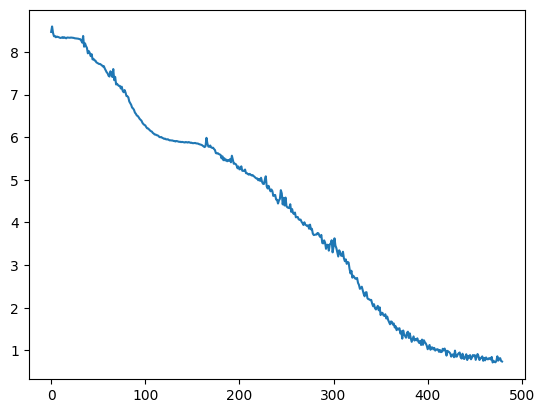

In [24]:
plt.plot(head_lossi);

In [10]:
print(f"number of parameters: {sum([p.numel() for p in head_bert.parameters()])}")

number of parameters: 4344630


In [11]:
count = 0

@torch.no_grad
def inference(x,):
    Ypr, Mpr, Dpr = head_bert(x.view(1, -1))
    year = torch.argmax(Ypr, dim=-1)
    month = torch.argmax(Mpr, dim=-1)
    day = torch.argmax(Dpr, dim=-1)
    return torch.cat((year, month, day), dim=0), f"{Config.ix2year.get(year.item())}-{Config.ix2month.get(month.item())}-{Config.ix2day.get(day.item())}"

In [13]:
test_dataset = DateDataset(tokenizer, Xts, Yts)
count = 0
for x, y in DataLoader(test_dataset, 1):
    if torch.all(inference(x)[0] == y):
        count += 1
count / len(test_dataset)

0.7646627565982405

In [68]:
head_bert.generate("1 فروردین سال هزار و چهارصد")

'1400-1-1'